In [27]:
import networkx as nx
import math
import fastnode2vec
from matplotlib import pyplot as plt

In [2]:
data_path = "/Users/alex/Library/CloudStorage/OneDrive-MUNI/Dokumenty/Projects Data/GNNs/cz_traffic/"
#data_path = "/media/sf_bely/OneDrive - MUNI/Dokumenty/Projects Data/GNNs/cz_traffic/"

In [3]:
G = nx.read_gpickle(data_path + 'czech_road_network.p')
print("G num of nodes = ", G.number_of_nodes(), "num of edges = ", G.number_of_edges())
isolated_nodes = [k for k, v in dict(G.degree()).items() if v == 0]
print("G, isolated nodes:", isolated_nodes)
G.remove_nodes_from(isolated_nodes)
print("G num of nodes = ", G.number_of_nodes(), "num of edges = ", G.number_of_edges())

G num of nodes =  1128 num of edges =  1153
G, isolated nodes: ['D04-012', 'D05-025', 'D35-014', 'I35-141']
G num of nodes =  1124 num of edges =  1153


In [4]:
list(G.edges(data=True))[:10]

[('D00-001', 'D00-002', {}),
 ('D00-001', 'D10-001', {}),
 ('D00-002', 'D00-003', {}),
 ('D00-002', 'D11-001', {}),
 ('D00-003', 'D00-004', {}),
 ('D00-003', 'D11-001', {}),
 ('D00-003', 'I12-001', {}),
 ('D00-004', 'D00-005', {}),
 ('D00-004', 'D01-005', {}),
 ('D00-004', 'D01-004', {})]

In [37]:
G2 = nx.read_gpickle(data_path + 'cz_road_network.p')
print("weighted G2 num of nodes = ", G2.number_of_nodes(), "num of edges = ", G2.number_of_edges())
isolated_nodes2 = [k for k, v in dict(G2.degree()).items() if v == 0]
print("weighted G2, isolated nodes:", isolated_nodes2)
G2.remove_nodes_from(isolated_nodes2)
print("weighted G2 num of nodes = ", G2.number_of_nodes(), "num of edges = ", G2.number_of_edges())

weighted G2 num of nodes =  1128 num of edges =  1153
weighted G2, isolated nodes: ['D04-012', 'D05-025', 'D35-014', 'I35-141']
weighted G2 num of nodes =  1124 num of edges =  1153


In [6]:
list(G2.edges(data=True))[:10]

[('D00-001', 'D00-002', {'weight': 1.2050837311556577}),
 ('D00-001', 'D10-001', {'weight': 2.5476607143833463}),
 ('D00-002', 'D00-003', {'weight': 1.2305560445026138}),
 ('D00-002', 'D11-001', {'weight': 4.208540877539873}),
 ('D00-003', 'D00-004', {'weight': 13.864838928754674}),
 ('D00-003', 'D11-001', {'weight': 4.359794366391371}),
 ('D00-003', 'I12-001', {'weight': 8.00865339673411}),
 ('D00-004', 'D00-005', {'weight': 4.745505898863562}),
 ('D00-004', 'D01-005', {'weight': 3.5671360137480663}),
 ('D00-004', 'D01-004', {'weight': 3.2169261012041366})]

In [10]:
def node2vec_embedding(G: nx.Graph, dim=32, weight='weight', walk_length=100, context=32, p=2.0, q=0.5, workers=4, seed=42):
    if nx.is_weighted(G):
        n2v_graph = fastnode2vec.Graph([(str(edge[0]), str(edge[1]), edge[2][weight]) for edge in G.edges(data=True)],
                directed=False, weighted=True)
    else:
        n2v_graph = fastnode2vec.Graph([(str(edge[0]), str(edge[1])) for edge in G.edges(data=True)],
                    directed=False, weighted=False)
    n2v = fastnode2vec.Node2Vec(n2v_graph, dim=dim, walk_length=walk_length, context=context, p=p, q=q, workers=workers, seed=seed)
    n2v.train(epochs=100)
    n2v_embeddings = [n2v.wv[str(node)] for node in G]
    return n2v_embeddings

### Unweighted G

In [8]:
embeddings = node2vec_embedding(G)

Training: 100%|██████████| 112400/112400 [00:17<00:00, 6283.35it/s]


In [9]:
# join embeddings with corresponding nodes (as x feature)
for idx, node in enumerate(G.nodes()):
    G.add_node(node, embedding=embeddings[idx])

### Weighted G2

In [11]:
embeddings2 = node2vec_embedding(G2)
# join embeddings with corresponding nodes (as x feature)
for idx, node in enumerate(G2.nodes()):
    G2.add_node(node, embedding=embeddings2[idx])

Training: 100%|██████████| 112400/112400 [00:17<00:00, 6552.10it/s]


In [12]:
G2.nodes['D00-001']

{'embedding': array([ 0.16008762, -0.54661536,  0.48544666,  0.2848445 ,  0.13352764,
        -0.3757031 , -1.0721117 ,  0.88858706, -0.22411333, -0.08394621,
        -0.33204773, -1.7601417 , -0.32556507,  0.29125914, -0.13358842,
        -0.08598834, -0.3125653 , -0.6418586 ,  0.34297508,  0.08136064,
         0.99849206,  0.36037084, -0.3815679 , -0.2396365 , -0.5723914 ,
         0.23879151, -0.0776656 ,  0.88638   , -0.69879216, -1.6238003 ,
         0.4058811 , -0.16648392], dtype=float32)}

In [ ]:
list(G2.edges(data=True))[:10]

[('D00-001', 'D00-002', {'weight': 1.2050837311556577}),
 ('D00-001', 'D10-001', {'weight': 2.5476607143833463}),
 ('D00-002', 'D00-003', {'weight': 1.2305560445026138}),
 ('D00-002', 'D11-001', {'weight': 4.208540877539873}),
 ('D00-003', 'D00-004', {'weight': 13.864838928754674}),
 ('D00-003', 'D11-001', {'weight': 4.359794366391371}),
 ('D00-003', 'I12-001', {'weight': 8.00865339673411}),
 ('D00-004', 'D00-005', {'weight': 4.745505898863562}),
 ('D00-004', 'D01-005', {'weight': 3.5671360137480663}),
 ('D00-004', 'D01-004', {'weight': 3.2169261012041366})]

In [ ]:
nx.readwrite.write_gpickle(G2, data_path + 'network32_my.gpickle')

### Re-weighted G3

In [30]:
scale = 5
edges = []
for v1, v2, w in G2.edges(data=True):
    distance = w['weight']
    edge = (v1, v2, {})
    edge[2]['dist'] = distance
    edge[2]['weight'] = math.exp(-(distance / scale)**2)
    edges.append(edge)
G3 = nx.from_edgelist(edges)

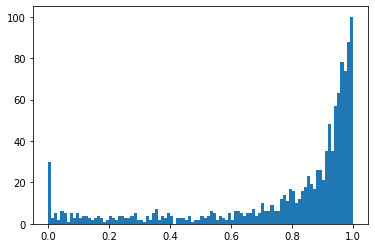

In [32]:
plt.hist([e[2]['weight'] for e in edges], bins=100);

In [33]:
embeddings3 = node2vec_embedding(G3)
# join embeddings with corresponding nodes (as x feature)
for idx, node in enumerate(G3.nodes()):
    G3.add_node(node, embedding=embeddings3[idx])

Training: 100%|██████████| 112400/112400 [00:17<00:00, 6361.94it/s]


In [36]:
nx.readwrite.write_gpickle(G3, data_path + 'network32_reweighted.gpickle')

# Old code follows

In [3]:
def generate_node_embeddings(graph: nx.Graph):
    model = Node2Vec(graph, dimensions=32, num_walks=100, walk_length=80, weight_key='dist', temp_folder='temp/', workers=2)
    result = model.fit(window=5, min_count=1)
    return result

In [5]:
%%time
embeddings = generate_node_embeddings(G)

Generating walks (CPU: 1): 100%|██████████| 50/50 [06:10<00:00,  7.41s/it]


CPU times: user 7min 6s, sys: 53 s, total: 7min 59s
Wall time: 6min 34s


In [7]:
embeddings.wv.most_similar('D00-001')

[('D10-001', 0.935806393623352),
 ('D00-002', 0.8871928453445435),
 ('D10-002', 0.7911334037780762),
 ('D00-003', 0.6844806671142578),
 ('D11-001', 0.683589518070221),
 ('D11-002', 0.6108906269073486),
 ('D10-003', 0.5654127597808838),
 ('I12-001', 0.4950152039527893),
 ('I12-002', 0.46955227851867676),
 ('D11-003', 0.41467419266700745)]

In [9]:
embeddings.save('data/embeddings32.data')

In [ ]:
# join embeddings with corresponding nodes (as x feature)
for idx, node in enumerate(G.nodes()):
    G.add_node(node, embedding=embeddings.wv[str(node)].copy())

In [ ]:
nx.readwrite.write_gpickle(G, 'data/network32.gpickle')